In [2]:
import numpy as np
import sklearn.decomposition
from data import create_datasources
from features import LogFiltSpec
from targets import ChordsMajMin
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline

# Load Data

In [2]:
train_set, val_set, test_set, gt_files = create_datasources(
    dataset_names=['beatles', 'queen', 'zweieck', 'robbie_williams', 'rwc'],
    preprocessors=[],
    compute_features=LogFiltSpec(frame_sizes=[8192], num_bands=24, fmax=5500, fps=10,
                                 unique_filters=False),
    compute_targets=ChordsMajMin(fps=10),
    context_size=0,
    test_fold=0
)

In [3]:
train_set.n_data

584067

# Create PCA

In [58]:
pca = sklearn.decomposition.PCA(whiten=True, n_components=144)

In [59]:
pca.fit(train_set[:][0])

PCA(copy=True, n_components=144, whiten=True)

# Create partial PCAs

In [60]:
n_data = 10000

In [61]:
pca_1 = sklearn.decomposition.PCA(whiten=True, n_components=144)
ts_1 = random.sample(range(train_set.n_data), n_data)
pca_1.fit(train_set[ts_1][0])

PCA(copy=True, n_components=144, whiten=True)

In [62]:
pca_2 = sklearn.decomposition.PCA(whiten=True, n_components=144)
ts_2 = random.sample(range(train_set.n_data), n_data)
pca_2.fit(train_set[ts_2][0])

PCA(copy=True, n_components=144, whiten=True)

# Plot Eigenvectors

In [63]:
r = max(abs(pca.components_).max(), abs(pca_1.components_).max(), abs(pca_2.components_).max())

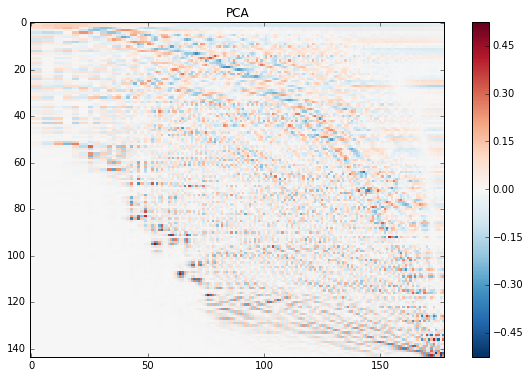

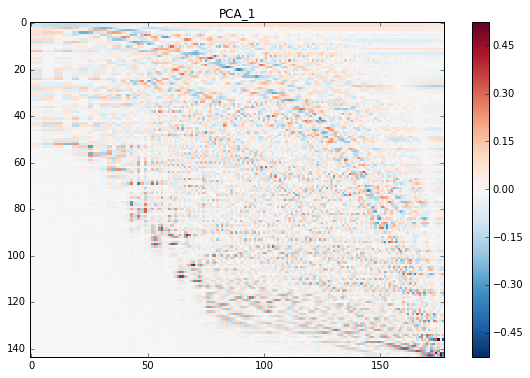

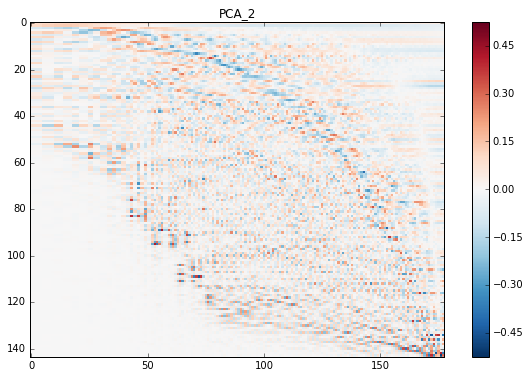

In [67]:
plt.figure(figsize=(10, 6))
plt.imshow(pca.components_, interpolation='none', cmap=plt.cm.RdBu_r, vmin=-r, vmax=r)
plt.colorbar()
plt.title('PCA')
plt.figure(figsize=(10, 6))
plt.imshow(pca_1.components_, interpolation='none', cmap=plt.cm.RdBu_r, vmin=-r, vmax=r)
plt.colorbar()
plt.title('PCA_1')
plt.figure(figsize=(10, 6))
plt.imshow(pca_2.components_, interpolation='none', cmap=plt.cm.RdBu_r, vmin=-r, vmax=r)
plt.colorbar()
plt.title('PCA_2')

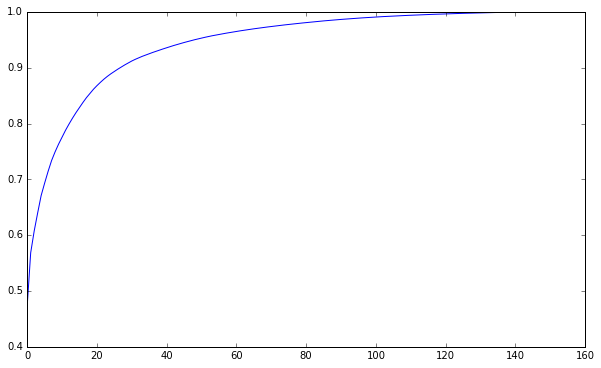

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(pca_1.explained_variance_ratio_.cumsum())

# Difference approximated PCA to PCA

In [81]:
diffs = []
n_datas = [200, 500, 700, 1000, 5000, 10000, 15000, 20000, 30000, 50000, 100000, 200000, 400000, 584067]
for n_data in n_datas:
    # fit partial pca with n_data vectors
    p_pca = sklearn.decomposition.PCA(whiten=True, n_components=144)
    ts = random.sample(range(train_set.n_data), n_data)
    p_pca.fit(train_set[ts][0])
    
    # compute differences to pca with all vectors
    vs = random.sample(range(val_set.n_data), 1000)
    p_p = p_pca.transform(val_set[vs][0])
    o_p = pca.transform(val_set[vs][0])
    p_pd = sklearn.metrics.pairwise_distances(p_p)
    o_pd = sklearn.metrics.pairwise_distances(o_p)
    diffs.append(np.median(abs(p_pd - o_pd)))

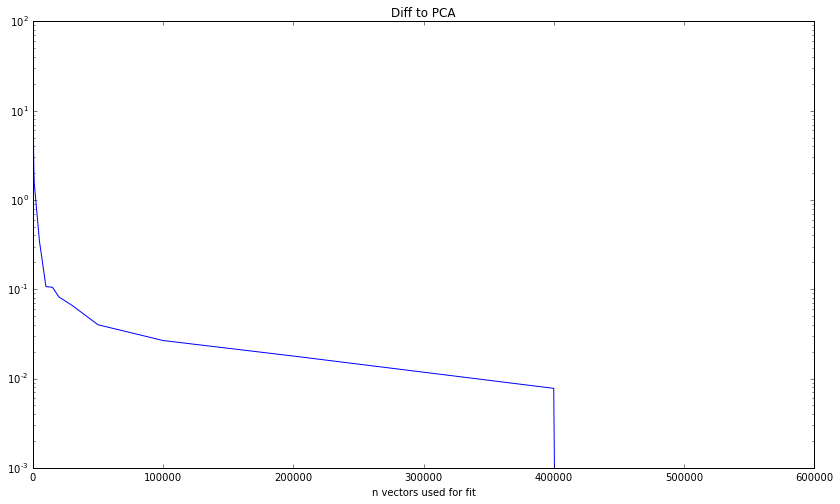

In [84]:
plt.figure(figsize=(14, 8))
plt.plot(n_datas, diffs)
plt.yscale('log')
plt.title('Diff to PCA')
plt.xlabel('n vectors used for fit')

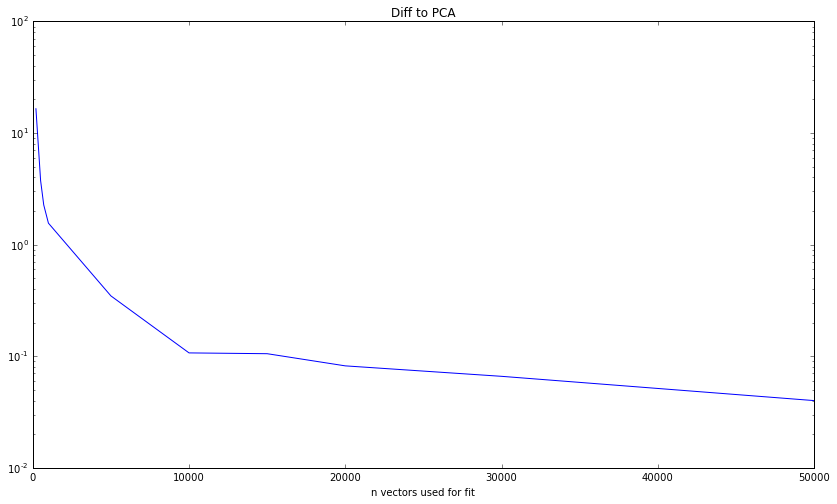

In [88]:
plt.figure(figsize=(14, 8))
plt.plot(n_datas[:10], diffs[:10])
plt.yscale('log')
plt.title('Diff to PCA')
plt.xlabel('n vectors used for fit')

# PCA with context features

In [3]:
train_set, val_set, test_set, gt_files = create_datasources(
    dataset_names=['beatles', 'queen', 'zweieck', 'robbie_williams', 'rwc'],
    preprocessors=[],
    compute_features=LogFiltSpec(frame_sizes=[8192], num_bands=24, fmax=5500, fps=10,
                                 unique_filters=False),
    compute_targets=ChordsMajMin(fps=10),
    context_size=7,
    test_fold=0
)

In [3]:
pca_ctx = sklearn.decomposition.PCA(whiten=True)

In [32]:
s = time.time()
ts_ctx = random.sample(range(train_set.n_data), 50000)
pca_ctx.fit(train_set[ts_ctx][0].reshape((50000, -1)))
print 'took', time.time() - s

took 75.3185799122


In [35]:
pca_ctx.explained_variance_ratio_.cumsum()[1330]

0.99007511

([], <a list of 0 Text yticklabel objects>)

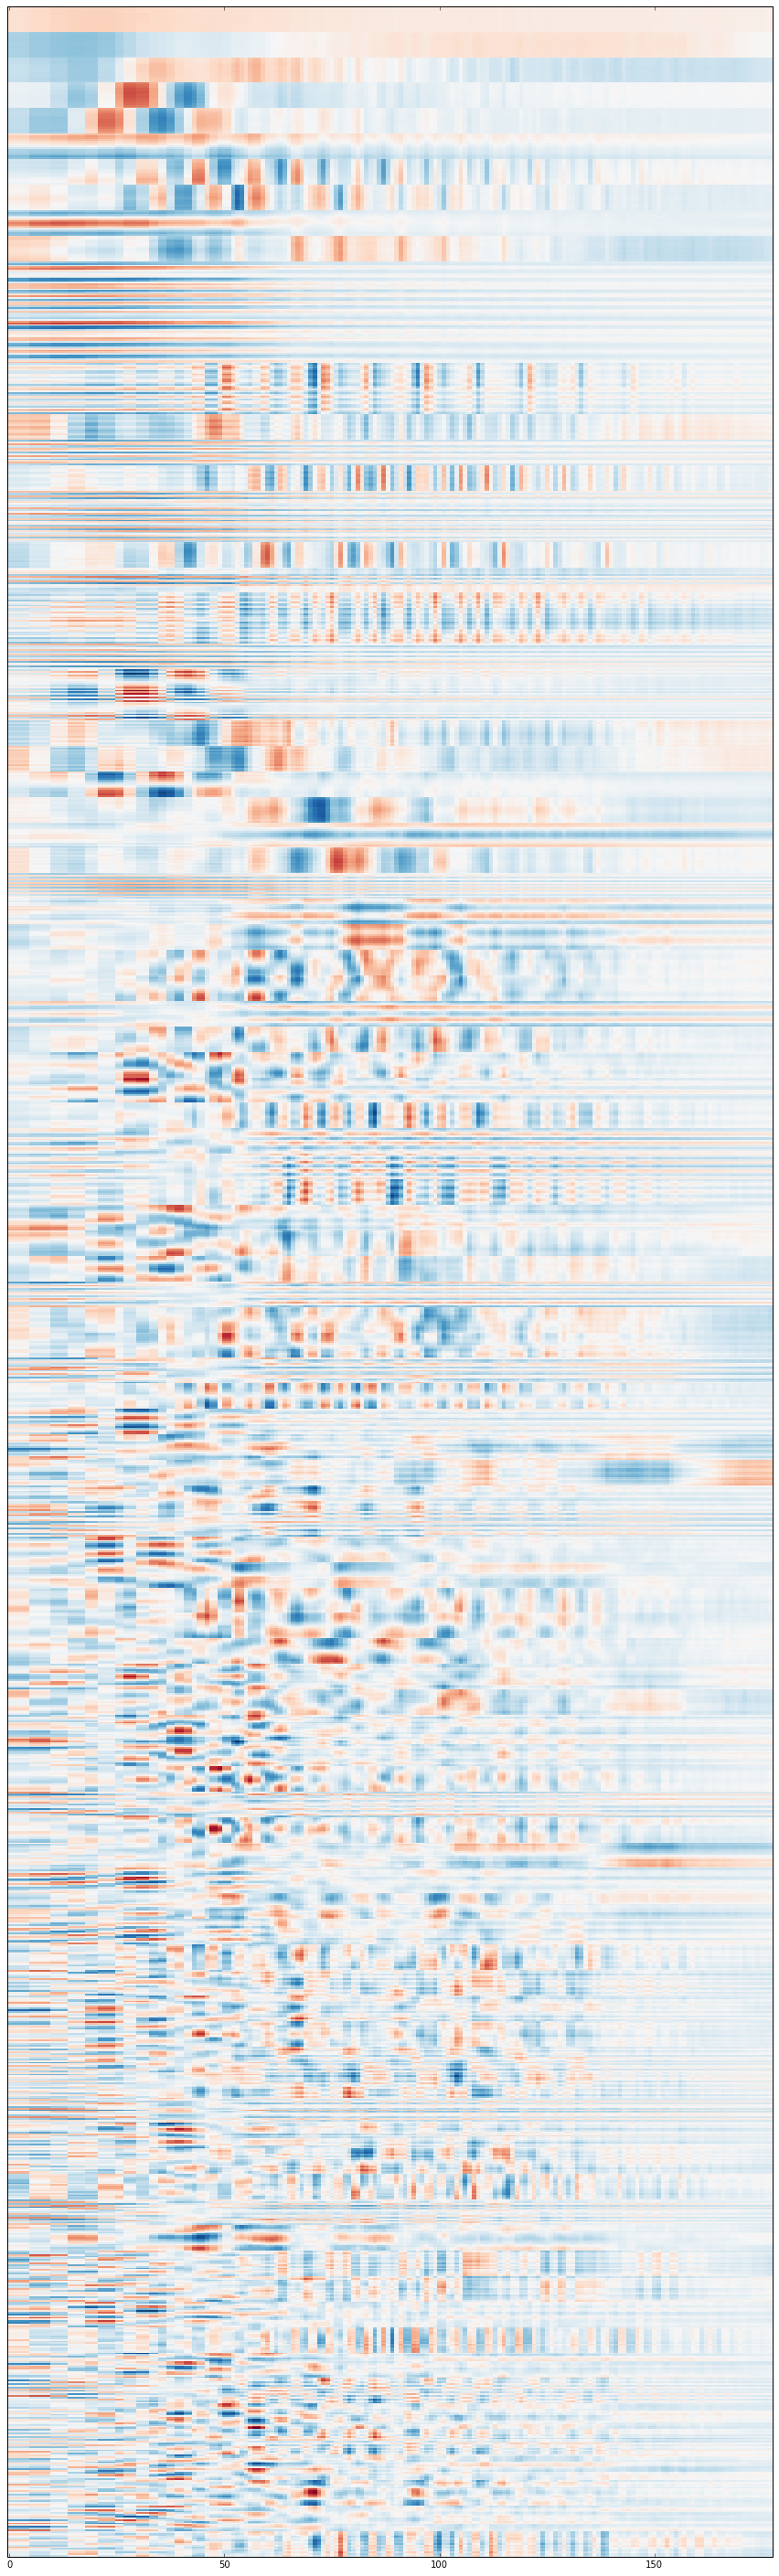

In [121]:
plt.figure(figsize=(15, 50))
plt.imshow(pca_ctx.components_.reshape((-1, 178))[:15*100], aspect='auto', cmap=plt.cm.RdBu_r, interpolation='none')
plt.yticks([])
#for y in range(0, 3000, 15):
#    plt.axhline(y, color='gray')

In [15]:
#
# author: matthias
#

import numpy as np
from scipy import linalg
from sklearn.utils import as_float_array
from sklearn.base import TransformerMixin, BaseEstimator
import theano.tensor as T
import theano


class ZCA(BaseEstimator, TransformerMixin):
    """
    Compute ZCA whitening
    """

    def __init__(self, regularization=10**-5, copy=True):
        """
        Constructor
        """
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """
        Compute whitening transform
        """
        print "Fitting Whitening Transform ..."
        X = np.reshape(X, (X.shape[0], -1))
        X = as_float_array(X, copy=self.copy)
        
        # center data        
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_
        
        # compute covmat
        #X_t = T.matrix('x')
        #sigma_t = T.dot(X_t.T, X_t) / (X.shape[1] - 1)
        #compute_sigma = theano.function([X_t], sigma_t)
        print "  Computing Covariance Matrix ..."
        sigma = np.dot(X.T, X) / (X.shape[1] - 1)
        #sigma = compute_sigma(X)
        
        # compute svd
        print "  Computing SVD ..."
        U, S, V = linalg.svd(sigma)
        
        # compute whitening transform
        print "  Compiling Transformation Matrix ..."
        tmp = np.dot(U, np.diag(1.0 / np.sqrt(S + self.regularization)))
        self.components_ = np.dot(tmp, U.T)
        
        print "  Done!"
        return self

    def transform(self, X):
        """
        Transform data
        """
        orig_shape = X.shape
        X = np.reshape(X, (X.shape[0], -1))
        X_transformed = X - self.mean_
        X_transformed = np.dot(X_transformed, self.components_.T)
        return X_transformed.reshape(orig_shape)

In [16]:
zca = ZCA()

In [17]:
s = time.time()
ts_ctx = random.sample(range(train_set.n_data), 50000)
zca.fit(train_set[ts_ctx][0].reshape((-1, 1, 15, 178)))
print 'took', time.time() - s

Fitting Whitening Transform ...
  Computing Covariance Matrix ...
  Computing SVD ...
  Compiling Transformation Matrix ...
  Done!
took 37.8554940224


In [18]:
x_t = zca.transform(train_set[:5000][0])

In [19]:
x = train_set[:5000][0]

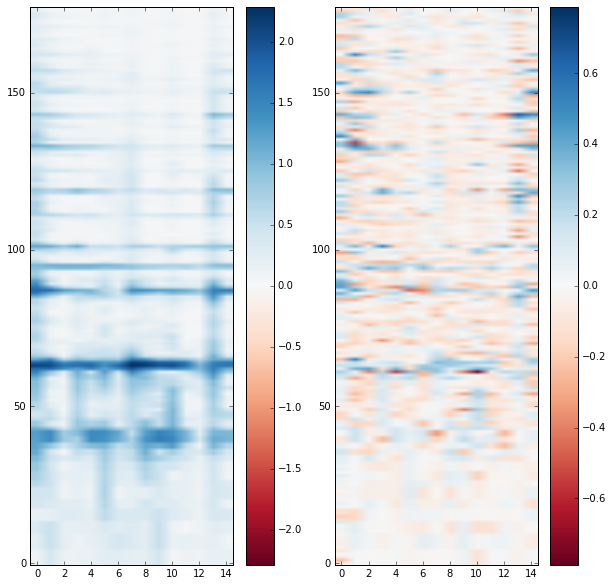

In [22]:
i = 1800
f = plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
r = max(abs(x[i].min()), abs(x[i].max()))
img = ax.imshow(x[i].T, origin='lower', aspect='auto', cmap=plt.cm.RdBu, vmin=-r, vmax=+r)
f.colorbar(img, ax=ax)
ax = plt.subplot(122)
r = max(abs(x_t[i].min()), abs(x_t[i].max()))
img = ax.imshow(x_t[i].T, origin='lower', aspect='auto', cmap=plt.cm.RdBu, vmin=-r, vmax=+r)
f.colorbar(img, ax=ax)